In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import kagglehub
import polars as pl
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import VisionTransformer
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import time

# Fetch the dataset from Kaggle

In [21]:

# Download latest version
path = kagglehub.dataset_download("shreyasraghav/shutterstock-dataset-for-ai-vs-human-gen-image")

print("Path to dataset files:", path)
train_data_path = os.path.join(path, "train.csv")

Path to dataset files: /home/dan/.cache/kagglehub/datasets/shreyasraghav/shutterstock-dataset-for-ai-vs-human-gen-image/versions/2


# Create a dataloader

In [26]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")  # Ensure RGB
        label = torch.tensor([float(self.labels[idx])], dtype=torch.float)  # Binary labels

        if self.transform:
            image = self.transform(image)
            image = image.unsqueeze(0)  # Add batch dimension

        return image, label

def load_data(data: pl.DataFrame, train_ratio: float = 0.8) -> tuple[DataLoader, DataLoader]:
    image_paths = data['path'].to_list()
    labels = data['label'].to_list()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataset = ImageDataset(image_paths, labels, transform=transform)
    # make sure the lengths of train/test add up to the original
    train_len = int(len(dataset) * train_ratio)
    test_len = len(dataset) - train_len
    train, test = torch.utils.data.random_split(dataset, [train_len, test_len])
    dataloader_train = DataLoader(train, batch_size=32, shuffle=True)
    dataloader_test = DataLoader(test, batch_size=32, shuffle=True)
    return dataloader_train, dataloader_test

# Setup the data loader

In [27]:
# setup the polars dataframe containing the path and label of the images
train_data = pl.read_csv(train_data_path)
# prepend the path with the path to the dataset
train_data = train_data.with_columns([pl.col("file_name").map_elements(lambda s: os.path.join(path, s), return_dtype=str).alias("path")])

In [28]:
dataloader_train, dataloader_test = load_data(train_data)
#display the first image
# img, label = next(iter(dataloader))
# print(img.shape, label.shape)
# plt.imshow(img[0].permute(1, 2, 0))

# Create the model architecture

In [35]:
class BinaryViT(nn.Module):
    def __init__(self):
        super(BinaryViT, self).__init__()
        self.vit = VisionTransformer(
                    image_size=224,    # Input image size
                    patch_size=16,     # Patch size
                    hidden_dim=768,          # Embedding dimension
                    num_layers=12,         # Number of transformer layers
                    num_heads=12,         # Number of attention heads
                    mlp_dim=3072,     # Feedforward MLP dimension
                    dropout=0.1,      # Dropout probability
                    num_classes=2  # Output classes
                )
        # replacing the head
        self.vit.heads = nn.Sequential(nn.Linear(self.vit.hidden_dim, 1))
    def forward(self, x):
        x = self.vit(x).squeeze(1)
        return x


# Training

In [36]:
from dataclasses import dataclass
@dataclass
class TrainReport:
    accuracies  : list[float]
    losses      : list[float]

def train(model: nn.Module, dataloader, criterion, optimizer, epochs, device) -> TrainReport:
    report = TrainReport([], [])
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            report.losses.append(loss.item())
            #outputs ar in range 0-1, for report just use 0.5 as threshold
            report.accuracies.append(((outputs > 0.5) == labels).float().mean().item())

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader)}")
    return report

In [37]:
data_for_train = torch.utils.data.Subset(dataloader_test.dataset, range(10))
model = BinaryViT()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
print('Training...')
start = time.time()
report = train(model, data_for_train, criterion, optimizer, 10, device)
print(f"Training took {time.time()-start:.2f} seconds")


Using device: cpu
Training...
Epoch 1/10, Loss: 1.1630346418474802
Epoch 2/10, Loss: 1.9997870794890331
Epoch 3/10, Loss: 0.3655889628396835
Epoch 4/10, Loss: 0.4249731660151156
Epoch 5/10, Loss: 0.19870849892540718
Epoch 6/10, Loss: 0.26706328604486773
Epoch 7/10, Loss: 0.30094072849351505
Epoch 8/10, Loss: 0.09557003364971024
Epoch 9/10, Loss: 0.12549252360549873
Epoch 10/10, Loss: 0.02184515555672988
Training took 262.09 seconds


# Plots

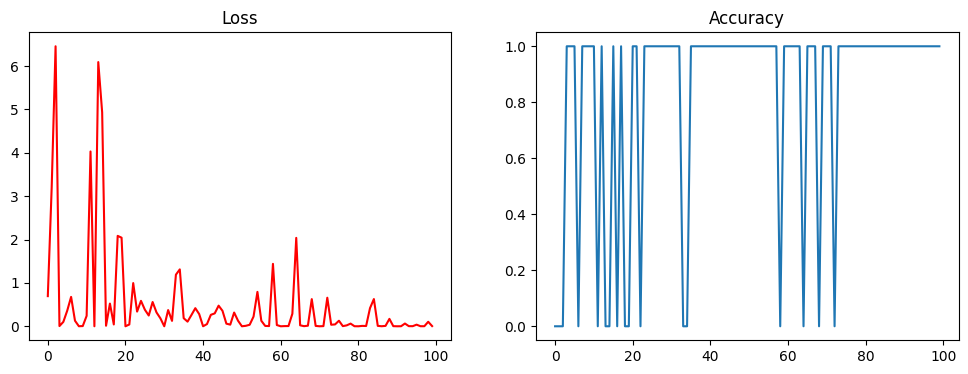

In [38]:
# plot the report loss and accuracy

def plot_report(report: TrainReport):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(report.losses, color='red')
    ax[0].set_title("Loss")
    ax[1].plot(report.accuracies)
    ax[1].set_title("Accuracy")
    plt.show()

plot_report(report)

# Save the model

In [39]:
torch.save(model.state_dict(), "model.pth")
print("Model saved as model.pth")

Model saved as model.pth
